<a href="https://colab.research.google.com/github/arunangshudutta/k-Distribution/blob/main/code/Copy_of_k_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch # pip install torch
from torch.utils import data
from torchvision import models, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")

from scipy.stats import skew # pip install scipy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

colors = [(0.0, 1.0, 0.0), (0.8083393600775954, 0.9910098252818546, 0.008454719027349511), (1.0, 0.0, 1.0), (0.8255298200269579, 0.01347223568611633, 0.0015930541073467808), (0.0, 1.0, 1.0), (0.03373412262990616, 0.47508185915422463, 0.20807599885851835), (0.0, 0.5, 1.0), (0.9958064936974211, 0.4750628143642702, 0.7304535784940589), (0.0, 0.0, 1.0), (0.0, 1.0, 0.5), (1.0, 0.5, 0.0), (0.5, 0.75, 0.5), (0.5347093878640534, 0.6118223130929942, 0.004915098046236688), (0.6170227460053966, 0.3274789280253205, 0.9936448615460967), (0.5372751462647845, 0.9466478885411327, 0.9523922512621626), (0.40458390488016094, 0.11498666466400409, 0.6082136601625988)]

sns.set_palette(colors)

#subset_labels = ['Airplane', 'Bear', 'Bicycle', 'Bird', 'Boat', 'Bottle', 'Car', 'Cat', 'Chair', 'Clock', 'Dog', 'Elephant', 'Keyboard', 'Knife', 'Oven', 'Truck']
n_components = 2

In [67]:
weights = models.ResNet50_Weights.IMAGENET1K_V1
model = models.resnet50(weights=weights)
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [68]:
directory_path = r"/content/drive/MyDrive/Colab Notebooks/imagenet_images"
dataset = datasets.ImageFolder(root=directory_path, transform=weights.transforms())
data_loader = data.DataLoader(dataset, batch_size=512, shuffle=False, num_workers=2)

In [69]:
# Assuming you've already created the dataset
class_to_idx = dataset.class_to_idx

# To get the inverse mapping (idx_to_class)
idx_to_class = {v: k for k, v in class_to_idx.items()}
subset_labels = list(idx_to_class.values())
print(subset_labels)

['Indian elephant', 'airliner', 'analog clock', 'barber chair', 'beach wagon', 'beer bottle', 'bicycle-built-for-two', 'brown bear', 'canoe', 'computer keyboard', 'hen', 'mix_data', 'tabby']


In [70]:

import os


def count_files_in_folders(directory):
    count = 0
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            print(f"{folder}: {file_count} files")
            count += file_count
    print(count)

# Usage

count_files_in_folders(directory_path)

airliner: 106 files
brown bear: 106 files
bicycle-built-for-two: 105 files
hen: 103 files
canoe: 113 files
beer bottle: 104 files
beach wagon: 105 files
tabby: 106 files
barber chair: 105 files
analog clock: 102 files
Indian elephant: 153 files
computer keyboard: 106 files
mix_data: 120 files
1434


In [71]:
x = data_loader.dataset[0]
print(len(data_loader.dataset))

1434


In [72]:
output, target = [], []
with torch.no_grad():
    for d in tqdm(data_loader):
        images, labels = d
        images, labels =  images.to(device), labels.to(device)
        out = model(images)
        output.extend(out)
        target.extend(labels.unsqueeze(1))

output = torch.stack(output).view(len(output), -1)
target = torch.stack(target)[:, 0]

100%|██████████| 3/3 [00:12<00:00,  4.18s/it]


In [73]:
del model, images, labels, dataset, data_loader
torch.cuda.empty_cache()

In [74]:
def check_heterogenity(data):
    for i, l in enumerate(data):
        if l != data[0]:
            return i

dist = torch.cdist(output, output, p=2)
sort = torch.argsort(dist, dim=1)
sorted_labels = torch.gather(torch.stack([target[:sort.shape[1]]] * sort.shape[0]), 1, sort)
sorted_labels = sorted_labels.detach().cpu().numpy()
_target = target.detach().cpu().numpy()

kvalues = np.array([check_heterogenity(x) for x in tqdm(sorted_labels)]).astype(np.float32)

skew_threshold = 0.5

mean, std, skew_data, pattern = [], [], [], []
for c in sorted(np.unique(_target)):
    idx = np.where(_target == c)[0]
    n = len(idx)

    kvalues[idx] = kvalues[idx]/n
    c_kdistribution = kvalues[idx]

    mean.append(c_kdistribution.mean())
    std.append(c_kdistribution.std())

    # c_kdistribution = np.array(list(c_kdistribution) + [0.0, 1.0])
    skew_value = skew(c_kdistribution)

    if np.isnan(skew_value):
        if c_kdistribution[0] == 1.0:
            skew_value = -np.inf
        elif c_kdistribution[0] == 0.0:
            skew_value = np.inf

    skew_data.append(skew_value)

    if skew_value < -skew_threshold:
        pattern.append("Clustered")
    elif skew_value > skew_threshold:
        pattern.append("Fractured")
    else:
        pattern.append("Overlapped")

mean, std, skew_data = np.array(mean), np.array(std), np.array(skew_data)
skew_data = np.nan_to_num(skew_data, nan=0.0, posinf=np.nanmax(skew_data[skew_data != np.inf]), neginf=np.nanmin(skew_data[skew_data != -np.inf]))

100%|██████████| 1434/1434 [00:00<00:00, 412752.67it/s]


## mix data with 10 images from each (12) class

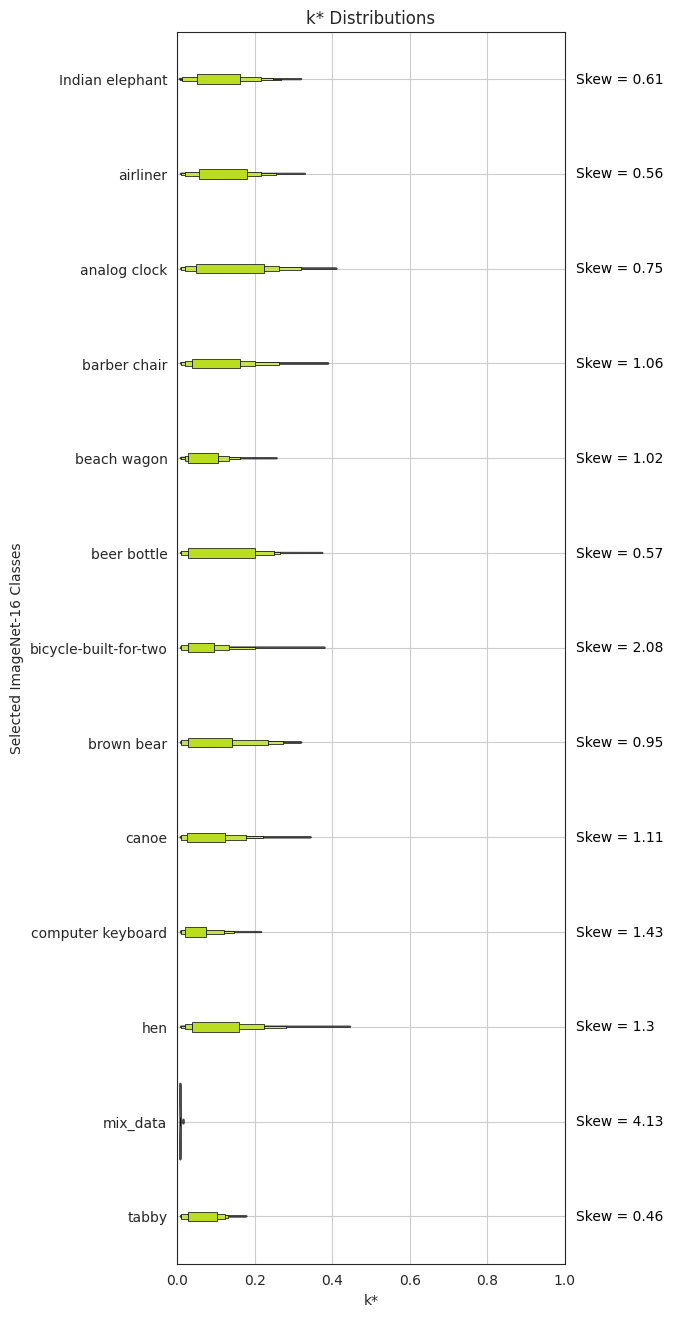

In [75]:
named_target = [subset_labels[x] for x in _target]
ddf = pd.DataFrame({"k*": kvalues, "Selected ImageNet-16 Classes": named_target})

named_values = subset_labels # ["Airplane", "Bicycle", "Car", "Dog", "Elephant", "Truck"]
df = ddf.loc[ddf['Selected ImageNet-16 Classes'].isin(named_values)]

x = df.groupby(['Selected ImageNet-16 Classes'])['k*'].mean().values
nobs = ["Skew = " + str(x.round(2)) for x in skew_data[[subset_labels.index(i) for i in named_values]]]

fig = plt.figure(num=1, clear=True, figsize=(5, 16))
ax = fig.subplots()

sns.violinplot(data=df, y="Selected ImageNet-16 Classes", x="k*", orient='h', cut=0,  inner=None, fill=False, saturation=0.5, ax=ax)

for i, violin in enumerate(ax.collections):
    violin.set_alpha(0.7)
    violin.set_edgecolor("black")

sns.boxenplot(data=df, y="Selected ImageNet-16 Classes", x="k*", orient='h', width=0.1, linewidth=.5, box_kws={'edgecolor':'black'}, line_kws=dict(linewidth=1.5, color="none"), flier_kws=dict(facecolor="none", edgecolor="none", linewidth=.5), ax=ax)

ax.set_xlim(0,1)

for tick in range(len(nobs)):
    ax.text(1.03, tick, nobs[tick], ha='left', va='center', color="black")
ax.set(title="k* Distributions")
ax.grid()

## mix data class with images mixed from arline and chair class

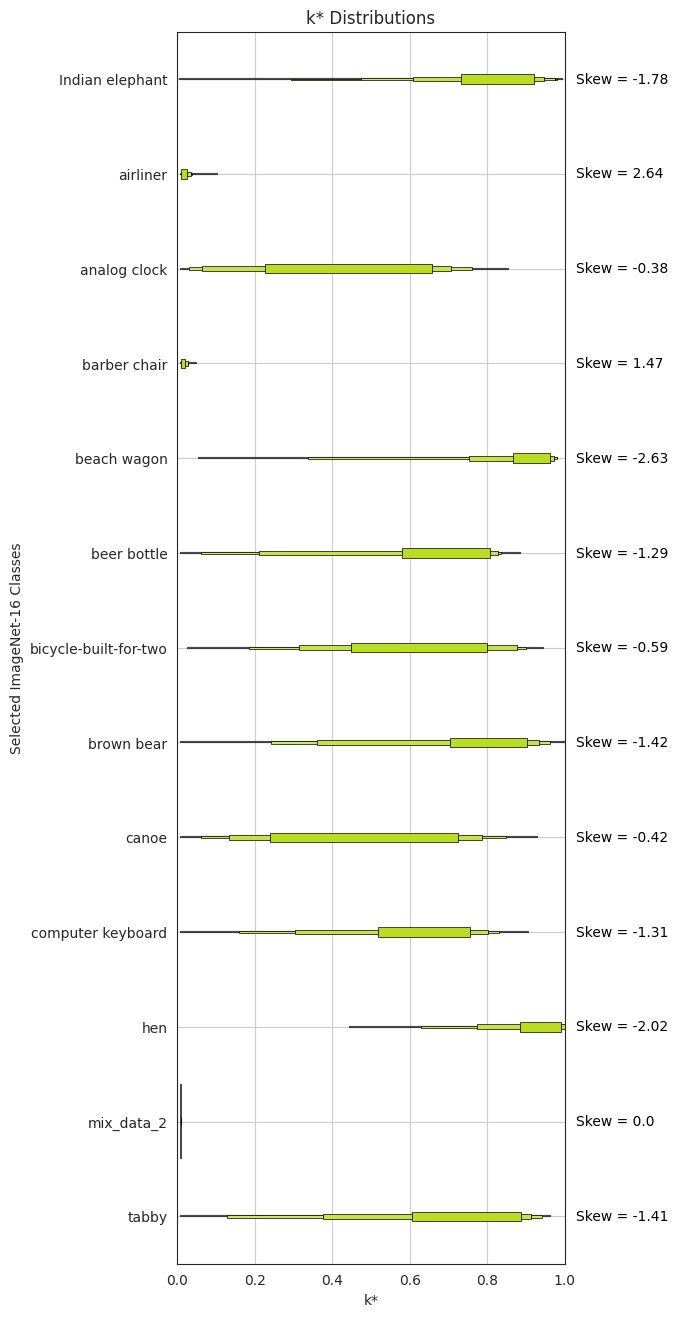

In [66]:
named_target = [subset_labels[x] for x in _target]
ddf = pd.DataFrame({"k*": kvalues, "Selected ImageNet-16 Classes": named_target})

named_values = subset_labels # ["Airplane", "Bicycle", "Car", "Dog", "Elephant", "Truck"]
df = ddf.loc[ddf['Selected ImageNet-16 Classes'].isin(named_values)]

x = df.groupby(['Selected ImageNet-16 Classes'])['k*'].mean().values
nobs = ["Skew = " + str(x.round(2)) for x in skew_data[[subset_labels.index(i) for i in named_values]]]

fig = plt.figure(num=1, clear=True, figsize=(5, 16))
ax = fig.subplots()

sns.violinplot(data=df, y="Selected ImageNet-16 Classes", x="k*", orient='h', cut=0,  inner=None, fill=False, saturation=0.5, ax=ax)

for i, violin in enumerate(ax.collections):
    violin.set_alpha(0.7)
    violin.set_edgecolor("black")

sns.boxenplot(data=df, y="Selected ImageNet-16 Classes", x="k*", orient='h', width=0.1, linewidth=.5, box_kws={'edgecolor':'black'}, line_kws=dict(linewidth=1.5, color="none"), flier_kws=dict(facecolor="none", edgecolor="none", linewidth=.5), ax=ax)

ax.set_xlim(0,1)

for tick in range(len(nobs)):
    ax.text(1.03, tick, nobs[tick], ha='left', va='center', color="black")
ax.set(title="k* Distributions")
ax.grid()

## With original data set 12 classes

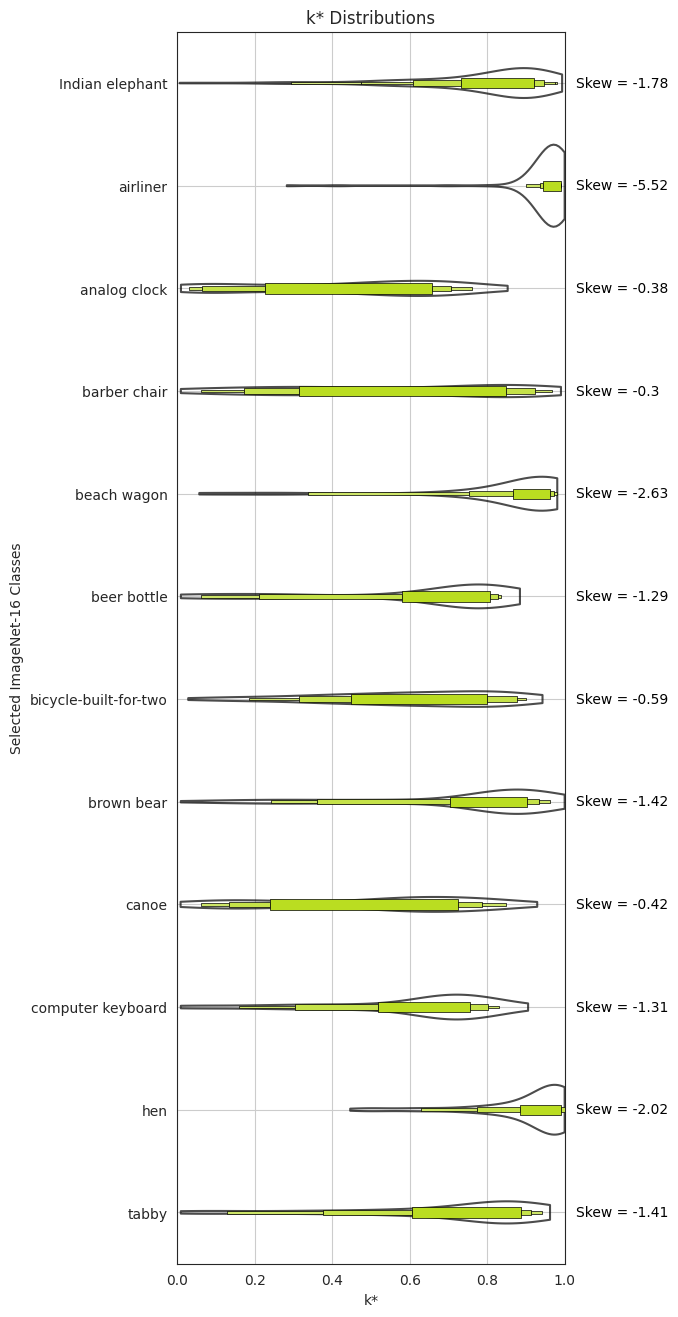

In [57]:
named_target = [subset_labels[x] for x in _target]
ddf = pd.DataFrame({"k*": kvalues, "Selected ImageNet-16 Classes": named_target})

named_values = subset_labels # ["Airplane", "Bicycle", "Car", "Dog", "Elephant", "Truck"]
df = ddf.loc[ddf['Selected ImageNet-16 Classes'].isin(named_values)]

x = df.groupby(['Selected ImageNet-16 Classes'])['k*'].mean().values
nobs = ["Skew = " + str(x.round(2)) for x in skew_data[[subset_labels.index(i) for i in named_values]]]

fig = plt.figure(num=1, clear=True, figsize=(5, 16))
ax = fig.subplots()

sns.violinplot(data=df, y="Selected ImageNet-16 Classes", x="k*", orient='h', cut=0,  inner=None, fill=False, saturation=0.5, ax=ax)

for i, violin in enumerate(ax.collections):
    violin.set_alpha(0.7)
    violin.set_edgecolor("black")

sns.boxenplot(data=df, y="Selected ImageNet-16 Classes", x="k*", orient='h', width=0.1, linewidth=.5, box_kws={'edgecolor':'black'}, line_kws=dict(linewidth=1.5, color="none"), flier_kws=dict(facecolor="none", edgecolor="none", linewidth=.5), ax=ax)

ax.set_xlim(0,1)

for tick in range(len(nobs)):
    ax.text(1.03, tick, nobs[tick], ha='left', va='center', color="black")
ax.set(title="k* Distributions")
ax.grid()